In [1]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'


In [2]:
import torch
from botorch import fit_gpytorch_model
from botorch.acquisition import UpperConfidenceBound
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
from botorch.models import SaasFullyBayesianSingleTaskGP
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch import constraints

# 目的関数の用意 (Rosenbrock関数)

In [3]:
def styblinski_tang(x):
    indices = [2, 3, 5, 7, 9]
    x_selected = x[..., indices]
    return 0.5 * torch.sum(x_selected ** 4 - 16 * x_selected ** 2 + 5 * x_selected, dim=-1)

In [4]:
# styblinski_tang関数の最適解
global_optimum = -39.16599 * 10

# 初期点の生成関数

In [5]:
def generate_initial_points(n_initial, dim, bounds):
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

# モデル作成関数


In [6]:
def create_model(train_X, train_Y):
    kernel = ScaleKernel(RBFKernel(ard_num_dims=train_X.shape[-1], noise_constraint=1e-5))
    model = SingleTaskGP(train_X, train_Y, covar_module=kernel)
    return model

# ドロップアウトベイズクラス

In [7]:
class DropoutMixBO:
    def __init__(self, dim, active_dim, bounds, n_initial, obj_function, dropout_prob=0.1):
        # クラスの初期化。パラメータを設定するよ
        self.dim = dim  # 全体の次元数
        self.active_dim = active_dim  # 活性化する次元数
        self.bounds = bounds  # 各次元の探索範囲
        self.obj_function = obj_function  # 最適化したい目的関数
        self.dropout_prob = dropout_prob  # ドロップアウトの確率
        self.X = generate_initial_points(n_initial, dim, bounds)  # 初期点を生成
        self.Y = self.obj_function(self.X)  # 初期点での目的関数の値を計算
        self.best_f = self.Y.min().item()  # 現在の最良の目的関数値
        self.best_x = self.X[self.Y.argmin()]  # 現在の最良の解
        self.eval_history = [self.best_f] * n_initial  # 評価履歴を初期化

    def optimize(self, n_iter):
        for _ in range(n_iter):  # 指定された回数だけ最適化を繰り返すよ
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims]  # 選んだ次元のデータだけ抽出
            train_Y = self.Y.unsqueeze(-1)  # Yの形状を調整
            model = create_model(train_X, train_Y)  # GPモデルを作成
            mll = ExactMarginalLogLikelihood(model.likelihood, model)  # 尤度関数を定義
            fit_gpytorch_model(mll)  # モデルを学習

            UCB = UpperConfidenceBound(model, beta=0.1)  # 獲得関数を定義
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])  # 活性化次元の探索範囲
            candidate, _ = optimize_acqf(  # 獲得関数を最適化して次の候補点を見つける
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)  # 新しい候補点を初期化
            if np.random.random() < self.dropout_prob:  # ドロップアウトを適用するかどうか決める
                x_new[active_dims] = candidate.squeeze()  # 活性化次元に候補点の値を設定
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)  # 非活性化次元を特定
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))  # 非活性化次元にランダムな値を設定
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()  # 活性化次元に候補点の値を設定
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[  # 非活性化次元に最良解の値を設定
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = self.obj_function(x_new.unsqueeze(0))  # 新しい候補点での目的関数値を計算

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])  # データセットに新しい点を追加
            self.Y = torch.cat([self.Y, y_new])  # 目的関数値のリストに新しい値を追加

            if y_new < self.best_f:  # もし新しい点が今までの最良値より良ければ
                self.best_f = y_new.item()  # 最良値を更新
                self.best_x = x_new  # 最良解を更新

            self.eval_history.append(self.best_f)  # 評価履歴に現在の最良値を追加

        return self.best_x, self.best_f  # 最適化が終わったら最良解と最良値を返す

# REMBO

In [8]:
class REMBO:
    def __init__(self, high_dim, low_dim, bounds, n_initial, obj_function):
        assert high_dim >= low_dim, "high_dim must be greater than or equal to low_dim"

        self.high_dim = high_dim
        self.low_dim = low_dim
        self.bounds = bounds
        self.obj_function = obj_function
        
        # すべてのテンソルをdouble型に変更
        self.A = torch.randn(high_dim, low_dim, dtype=torch.double)
        
        self.X_low = (torch.randn(n_initial, low_dim, dtype=torch.double) * 2 - 1)
        
        self.X_high = torch.clamp(self.X_low @ self.A.t(), bounds[0], bounds[1])
        assert self.X_high.shape == (n_initial, high_dim), f"Expected shape {(n_initial, high_dim)}, but got {self.X_high.shape}"
        
        self.Y = self.obj_function(self.X_high)
        
        self.best_f = self.Y.min().item()
        self.best_x = self.X_high[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            train_X_low = self.X_low
            train_Y = self.Y.unsqueeze(-1)
            model = SingleTaskGP(train_X_low, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            
            bounds_low = torch.stack([torch.ones(self.low_dim, dtype=torch.double) * -1, torch.ones(self.low_dim, dtype=torch.double)])
            candidate_low, _ = optimize_acqf(
                UCB, bounds=bounds_low, q=1, num_restarts=5, raw_samples=20,
            )

            x_high = torch.clamp(candidate_low @ self.A.t(), self.bounds[0], self.bounds[1])
            y_new = self.obj_function(x_high)

            self.X_low = torch.cat([self.X_low, candidate_low])
            self.X_high = torch.cat([self.X_high, x_high])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_high.squeeze()

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# BC-UCBアルゴリズムを取り入れたDropoutMixBO_BCUCBクラス

In [ ]:
class DropoutMixBO_BC_UCB:
    def __init__(self, dim, active_dim, bounds, n_initial, obj_function, dropout_prob=0.1, epsilon=0.05,
                 temperature=1e-3, reset_interval=1000, learning_rate=0.005, initial_beta=0.1, annealing_rate=1000):
        # クラスの初期化。たくさんのパラメータを設定するよ
        self.dim = dim  # 全体の次元数
        self.active_dim = active_dim  # 活性化する次元数
        self.bounds = bounds  # 各次元の探索範囲
        self.dropout_prob = dropout_prob  # ドロップアウトの確率
        self.obj_function = obj_function  # 最適化したい目的関数
        self.epsilon = epsilon  # ε-greedy法のパラメータ
        self.temperature = temperature  # ソフトマックスの温度パラメータ
        self.reset_interval = reset_interval  # リセット間隔
        self.iteration = 0  # イテレーション回数
        self.learning_rate = learning_rate  # 学習率
        self.initial_beta = initial_beta  # UCBのβの初期値
        self.annealing_rate = annealing_rate  # アニーリングレート

        initial_X = self.generate_initial_points(n_initial, dim, bounds)  # 初期点を生成
        initial_Y = obj_function(initial_X)  # 初期点での目的関数値を計算

        self.X = torch.tensor(initial_X, dtype=torch.double)  # データ点
        self.Y = torch.tensor(initial_Y, dtype=torch.double)  # 目的関数値

        self.best_f = self.Y.min().item()  # 現在の最良の目的関数値
        self.best_x = self.X[self.Y.argmin()]  # 現在の最良の解
        self.eval_history = [self.best_f] * n_initial  # 評価履歴
        self.improvement_history = []  # 改善履歴

        self.arm_rewards = np.zeros(dim)  # 各次元（腕）の報酬
        self.arm_counts = np.zeros(dim)  # 各次元（腕）の選択回数
        self.total_pulls = 0  # 総選択回数
        self.dim_importance = np.ones(dim) / dim  # 各次元の重要度
        self.dim_sensitivity = np.zeros(dim)  # 各次元の感度

        self.arm_selection_history = []  # 次元選択の履歴
        self.sigma_history = []  # 予測標準偏差の履歴

    def generate_initial_points(self, n_initial, dim, bounds):
        # 初期点をランダムに生成する関数
        return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

    def select_active_dims(self):
        # 活性化する次元を選択する関数
        self.iteration += 1

        if np.random.random() < max(self.epsilon * np.exp(-self.iteration / 10000), 0.01):
            # ε-greedy法：ランダムに選択
            selected_arms = np.random.choice(self.dim, self.active_dim, replace=False)
        else:
            # UCBスコアに基づいて選択
            ucb_scores = self.calculate_ucb_scores()
            
            # UCBスコアの正規化
            ucb_scores = np.clip(ucb_scores, -10, 10)  # 極端な値をクリップ
            ucb_scores = ucb_scores - np.min(ucb_scores)  # 最小値を0にシフト
            max_score = np.max(ucb_scores)
            if max_score > 0:
                ucb_scores = ucb_scores / max_score  # 最大値を1に正規化
            
            # ソフトマックスの適用
            probabilities = softmax(ucb_scores / self.temperature)
            
            # NaNやinfの処理
            probabilities = np.nan_to_num(probabilities, nan=1.0/self.dim, posinf=1.0, neginf=0.0)
            
            # 確率の正規化
            probabilities = np.clip(probabilities, 1e-10, 1)
            probabilities /= probabilities.sum()
            
            selected_arms = np.random.choice(self.dim, self.active_dim, replace=False, p=probabilities)

        # 選択された次元を記録
        arm_selection = np.zeros(self.dim)
        arm_selection[selected_arms] = 1
        self.arm_selection_history.append(arm_selection)

        # 定期的にリセット
        if self.iteration % self.reset_interval == 0:
            self.arm_rewards *= 0.5
            self.arm_counts *= 0.5

        return selected_arms

    def calculate_ucb_scores(self):
        # UCBスコアを計算する関数
        exploration_term = np.sqrt(2 * np.log(self.total_pulls + 1) / (self.arm_counts + 1e-5))
        exploitation_term = self.arm_rewards / (self.arm_counts + 1e-5)
        
        # アニーリングスケジュールの導入
        beta = self.initial_beta * np.exp(-self.iteration / self.annealing_rate)
        
        ucb_scores = exploitation_term + beta * exploration_term
        return ucb_scores * self.dim_importance

    def calculate_dimension_sensitivity(self):
        # 各次元の感度を計算する関数
        sensitivities = np.zeros(self.dim)
        for i in range(self.dim):
            sorted_indices = np.argsort(self.X[:, i])
            sorted_y = self.Y[sorted_indices]
            diffs = np.diff(sorted_y) / np.diff(self.X[sorted_indices, i])
            sensitivities[i] = np.mean(np.abs(diffs))
        
        total_sensitivity = np.sum(sensitivities) + 1e-10
        self.dim_sensitivity = sensitivities / total_sensitivity
        
        # 指数移動平均を使用して感度を更新
        alpha = 0.1  # 平滑化係数
        self.dim_sensitivity = alpha * self.dim_sensitivity + (1 - alpha) * self.dim_sensitivity

    def update_bandit(self, selected_dims, y_new):
        # バンディットアルゴリズムの更新
        improvement = max(0, self.best_f - y_new)
        relative_improvement = improvement / (abs(self.best_f) + 1e-8)
        
        self.total_pulls += 1
        for dim in selected_dims:
            self.arm_counts[dim] += 1
            arm_contribution = relative_improvement * self.dim_sensitivity[dim] / (sum(self.dim_sensitivity[selected_dims]) + 1e-10)
            self.arm_rewards[dim] += arm_contribution
        
        importance_update = self.dim_sensitivity / (np.sum(self.dim_sensitivity) + 1e-10)
        self.dim_importance = (1 - self.learning_rate) * self.dim_importance + self.learning_rate * importance_update
        self.dim_importance = np.clip(self.dim_importance, 1e-10, 1)
        self.dim_importance /= np.sum(self.dim_importance)
    
        # 報酬の正規化を追加
        self.arm_rewards = (self.arm_rewards - np.mean(self.arm_rewards)) / (np.std(self.arm_rewards) + 1e-8)

    def create_model(self, train_X, train_Y):
        # GPモデルを作成する関数
        model = SingleTaskGP(train_X, train_Y)
        return model

    def optimize(self, n_iter):
        # 最適化のメイン関数。指定された回数だけ繰り返して最適な解を探すよ
        for _ in range(n_iter):
            # 活性化する次元を選択。これで探索空間を絞り込むんだ
            active_dims = self.select_active_dims()

            # 選択された次元のデータだけを使ってモデルを学習するよ
            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)

            # ガウス過程回帰モデルを作成。これで未知の点の値を予測できるようになるんだ
            model = self.create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            # Upper Confidence Bound (UCB) 獲得関数を定義。
            # これは探索（未知の領域）と活用（既知の良い領域）のバランスを取るんだ
            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]]).double()

            # UCB獲得関数を最適化して、次に評価すべき候補点を見つけるよ
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=10, raw_samples=100,
                options={"maxiter": 200, "batch_limit": 5}
            )

            # 新しい候補点を生成。選択されなかった次元は最良の既知の点の値を使うよ
            x_new = torch.zeros(self.dim, dtype=torch.double)
            x_new[active_dims] = candidate.squeeze()
            x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                np.setdiff1d(range(self.dim), active_dims)]

            # 新しい候補点での目的関数の値を計算
            y_new = self.obj_function(x_new.unsqueeze(0))

            # 各次元の感度を計算。これで重要な次元を特定できるんだ
            self.calculate_dimension_sensitivity()

            # モデルを使って新しい点での予測標準偏差を計算。
            # これは不確実性の指標として使えるよ
            with torch.no_grad():
                pred = model(x_new[active_dims].unsqueeze(0))
            sigma = pred.stddev.item()
            self.sigma_history.append(sigma)

            # 改善量を計算して、バンディットアルゴリズムを更新
            # これで各次元の重要度を学習していくんだ
            improvement = max(0, self.best_f - y_new.item())
            self.update_bandit(active_dims, y_new.item())
            self.improvement_history.append(improvement)

            # もし新しい点が今までの最良値より良ければ、最良解を更新
            if y_new.item() < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            # 評価履歴に現在の最良値を追加
            self.eval_history.append(self.best_f)

        # 次元選択の履歴をDataFrameに変換。これで後で分析しやすくなるんだ
        self.arm_selection_df = pd.DataFrame(self.arm_selection_history,
                                            columns=[f'Arm_{i}' for i in range(self.dim)])
        self.arm_selection_df.index.name = 'Iteration'

        # 最適化が終わったら、最良の解と最良の目的関数値を返すよ
        return self.best_x, self.best_f

    # 以下、結果の可視化や保存のための関数たち
    def save_arm_selection_history(self, filename):
        self.arm_selection_df.to_csv(filename)

    def plot_sigma_history(self):
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.sigma_history) + 1), self.sigma_history)
        plt.xlabel('Iteration')
        plt.ylabel('Predicted Standard Deviation')
        plt.title('Predicted Standard Deviation vs Iteration')
        plt.grid(True)
        plt.show()

    def plot_dim_importance(self):
        plt.figure(figsize=(12, 6))
        plt.bar(range(self.dim), self.dim_importance)
        plt.xlabel('Dimension')
        plt.ylabel('Importance')
        plt.title('Dimension Importance')
        plt.xticks(range(self.dim))
        plt.grid(True)
        plt.show()

    def plot_dim_sensitivity(self):
        plt.figure(figsize=(12, 6))
        plt.bar(range(self.dim), self.dim_sensitivity)
        plt.xlabel('Dimension')
        plt.ylabel('Sensitivity')
        plt.title('Dimension Sensitivity')
        plt.xticks(range(self.dim))
        plt.grid(True)
        plt.show()

# 最適化の実行


In [10]:
dim = 10
active_dim = 5
bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
n_initial = 200
n_iter = 2000

In [11]:
dropout_bo_mix = DropoutMixBO(dim, active_dim, bounds, n_initial, styblinski_tang, dropout_prob=0.1)
dropout_bo_copy = DropoutMixBO(dim, active_dim, bounds, n_initial, styblinski_tang, dropout_prob=0.0)
dropout_bo_random = DropoutMixBO(dim, active_dim, bounds, n_initial, styblinski_tang, dropout_prob=1.0)
dropout_bandit_bc_ucb = DropoutMixBO_BC_UCB(dim, active_dim, bounds, n_initial, styblinski_tang, dropout_prob=0.0)
rembo = REMBO(dim, active_dim, bounds, n_initial, styblinski_tang)

C:\Users\nomuyu\AppData\Local\Temp\ipykernel_20020\1061307453.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(initial_X, dtype=torch.double)  # データ点
C:\Users\nomuyu\AppData\Local\Temp\ipykernel_20020\1061307453.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(initial_Y, dtype=torch.double)  # 目的関数値


In [12]:
try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      dropout_mix_best_x , dropout_mix_best_f = dropout_bo_mix.optimize(n_iter)
      pbar.update(20)
      dropout_copy_best_x , dropout_copy_best_f = dropout_bo_copy.optimize(n_iter)
      pbar.update(20)
      dropout_random_best_x , dropout_random_best_f = dropout_bo_random.optimize(n_iter)
      pbar.update(20)
      rembo_best_x, rembo_best_f = rembo.optimize(n_iter)
      pbar.update(20) 
      pbar.update(10)
      dropout_bandit_bc_ucb_best_x, dropout_bandit_bc_ucb_best_f = dropout_bandit_bc_ucb.optimize(n_iter)
      dropout_bandit_bc_ucb.save_arm_selection_history('dropout_bandit_bc_ucb_arm_selection_binary.csv')
      pbar.update(10)
    
except subprocess.CalledProcessError:
  print(captured)
  raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

## アームの履歴 BC_UCBのバンディット

           Arm_0  Arm_1  Arm_2  Arm_3  Arm_4  Arm_5  Arm_6  Arm_7  Arm_8  \
Iteration                                                                  
0            1.0    1.0    0.0    1.0    1.0    1.0    0.0    0.0    0.0   
1            0.0    0.0    1.0    0.0    0.0    0.0    1.0    1.0    1.0   
2            1.0    0.0    1.0    0.0    0.0    1.0    0.0    1.0    0.0   
3            0.0    0.0    0.0    1.0    0.0    0.0    1.0    1.0    1.0   
4            0.0    1.0    0.0    1.0    1.0    0.0    1.0    0.0    1.0   

           Arm_9  
Iteration         
0            0.0  
1            1.0  
2            1.0  
3            1.0  
4            0.0  


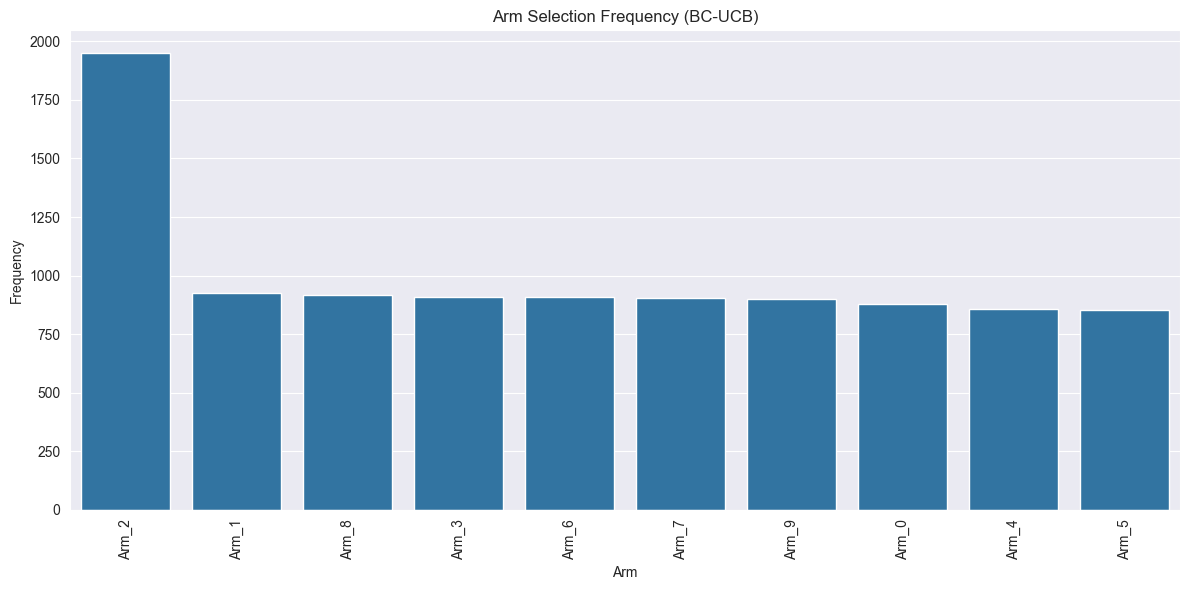

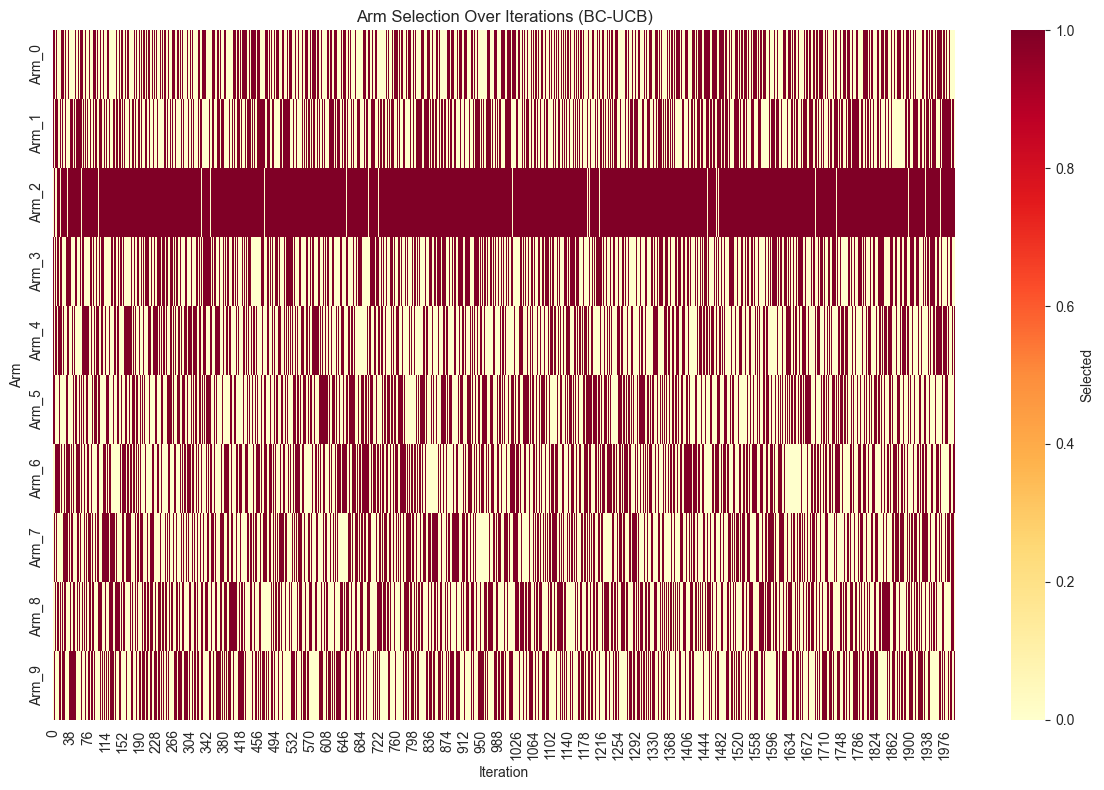

In [13]:
# Load the saved CSV file
df = pd.read_csv("dropout_bandit_bc_ucb_arm_selection_binary.csv", index_col="Iteration")

# Display the first few rows of the DataFrame
print(df.head())

# Calculate arm selection frequency
arm_freq = df.sum().sort_values(ascending=False)

# Create a bar plot of arm selection frequency
plt.figure(figsize=(12, 6))
sns.barplot(x=arm_freq.index, y=arm_freq.values)
plt.title("Arm Selection Frequency (BC-UCB)")
plt.xlabel("Arm")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create a heatmap of arm selection over iterations
plt.figure(figsize=(12, 8))
sns.heatmap(df.T, cmap="YlOrRd", cbar_kws={'label': 'Selected'})
plt.title("Arm Selection Over Iterations (BC-UCB)")
plt.xlabel("Iteration")
plt.ylabel("Arm")
plt.tight_layout()
plt.show()

## Dropout_Banditのimprovementのプロット

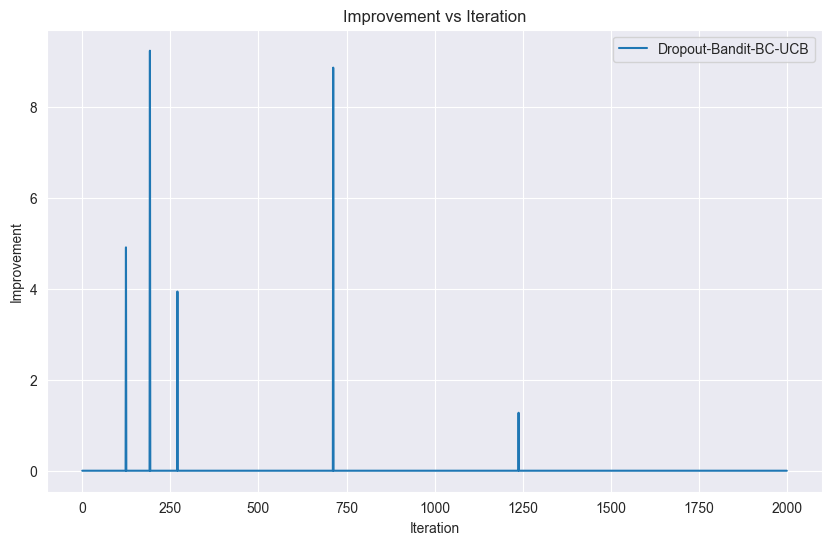

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(dropout_bandit_bc_ucb.improvement_history)), dropout_bandit_bc_ucb.improvement_history, label='Dropout-Bandit-BC-UCB')
plt.xlabel('Iteration')
plt.ylabel('Improvement')
plt.title('Improvement vs Iteration')
plt.legend()
plt.grid(True)
plt.show()

## Dropout_Banditのsigmaのプロット

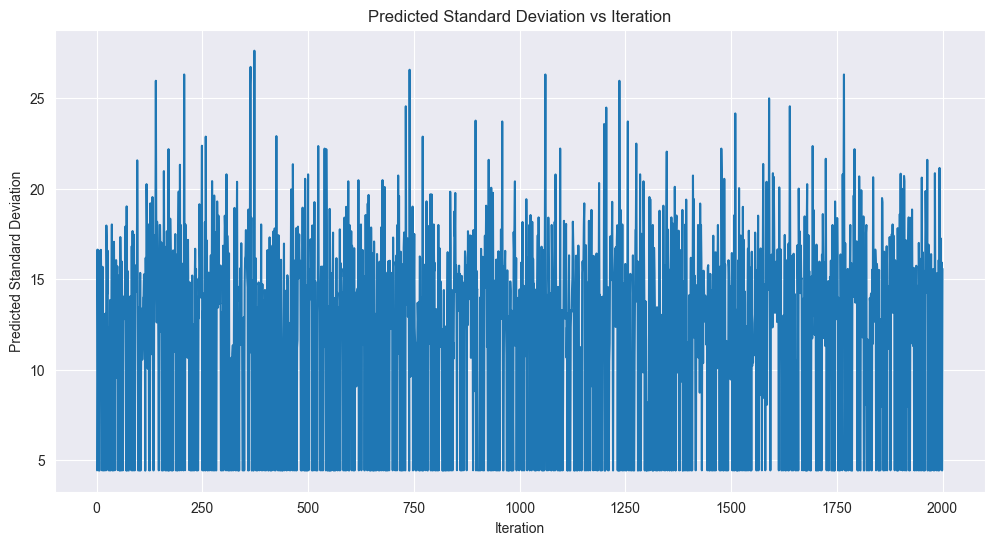

In [15]:
dropout_bandit_bc_ucb.plot_sigma_history()

## Dropout_Banditの次元重要度のプロット

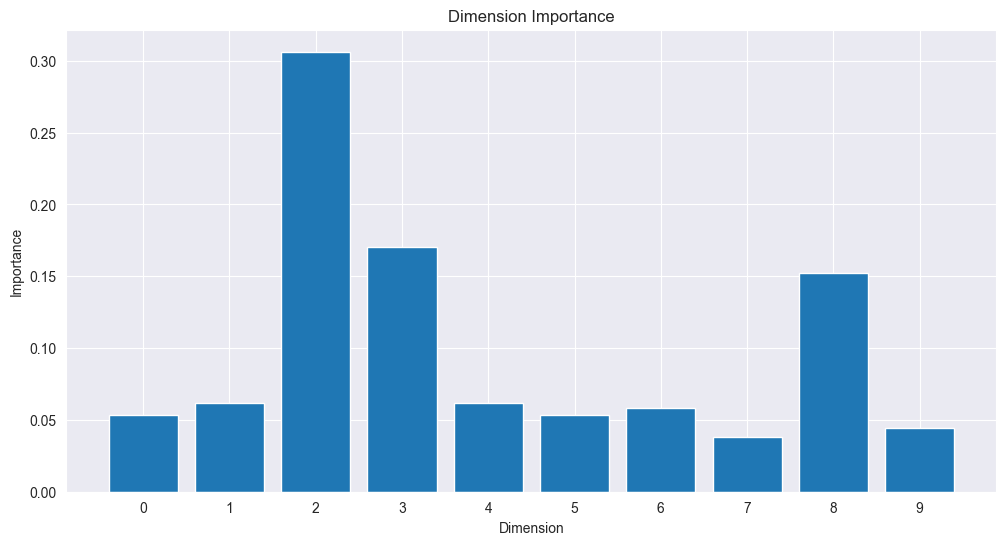

In [16]:
dropout_bandit_bc_ucb.plot_dim_importance()

# 結果のプロット

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


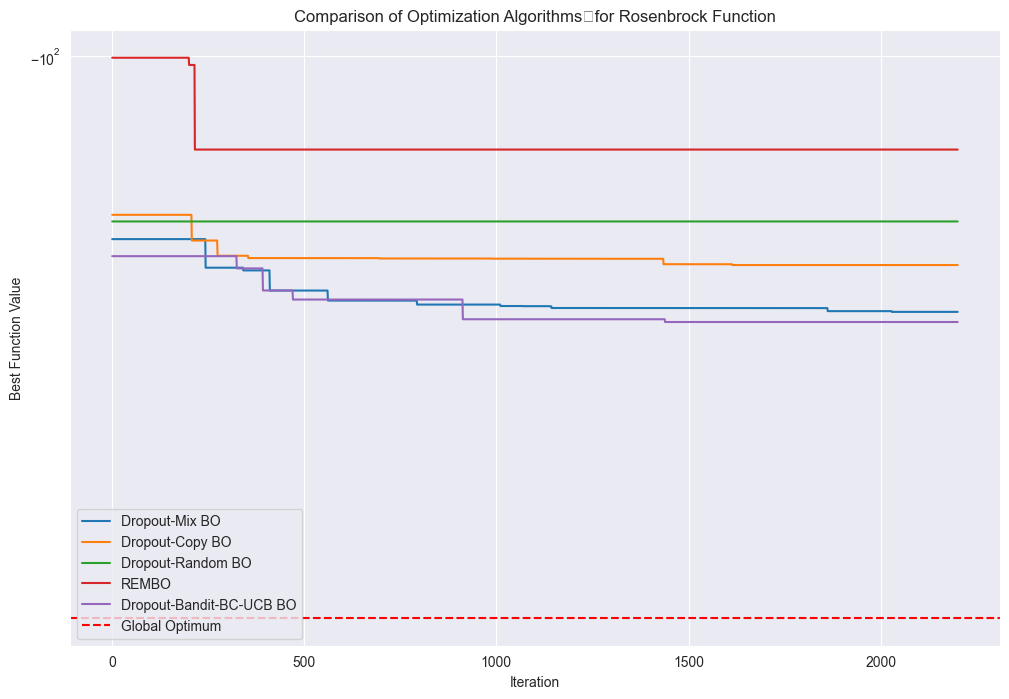

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_mix.eval_history, label='Dropout-Mix BO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_copy.eval_history, label='Dropout-Copy BO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_random.eval_history, label='Dropout-Random BO')
plt.plot(range(1, n_initial + n_iter + 1), rembo.eval_history, label='REMBO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bandit_bc_ucb.eval_history, label='Dropout-Bandit-BC-UCB BO')
plt.axhline(y=global_optimum, color='r', linestyle='--', label='Global Optimum')
plt.xlabel('Iteration')
plt.ylabel('Best Function Value')
plt.title('Comparison of Optimization Algorithms　for Rosenbrock Function')
plt.legend()
plt.yscale('symlog')
plt.grid(True)
plt.show()